# Bioreactor Optimization Using Machine Learning
### CHE 883 Final Project 
##### Sam Schulte and Lauren Murray
##### April 25, 2025

The purpose of this project is to recreate the work of the following paper: 

[Y. Ma, D. A. Noreña-Caro, A. J. Adams, T. B. Brentzel, J. A. Romagnoli, and M. G. Benton, “Machine-learning-based simulation and fed-batch control of cyanobacterial-phycocyanin production in Plectonema by artificial neural network and deep reinforcement learning,” Computers & Chemical Engineering, vol. 142, p. 107016, Jul. 2020, doi: 10.1016/j.compchemeng.2020.107016.](https://www.sciencedirect.com/science/article/abs/pii/S0098135420300545)

--- 
### Table of Contents
* [Introduction](#Introduction)
* [Importing Libraries](#Importing-Libraries)
* [Importing Data](#Importing-Data)
* [Data Preprocessing](#Data-Preprocessing)
    * [REGEM Imputation](#REGEM-Imputation)
    * [Polynomial Fitting](#Polynomial-Fitting)
    * Formatting Training and Validation Data for ANN
    * Scaling

---
### Introduction

This paper aimed to generate a machine learning (ML)-based strategy for optimizing the production of cyanobacterial-phycocyanin (C-PC), a valuable product produced by *Plectonoma* cyanobacteria. A deep reinforcement learning (DRL) algorithm, which are highly proficient with control tasks, was implemented to determine the optimal amount and timing of nitrate to add in a fed-batch culture to optimize C-PC production. In DRL, an agent interacts with an environment to maximize a reward in order to determine the best action to take. 

One challenge in implementing DRL is the need for many iterations to reach convergence, requiring a simulated reaction environment to model actions. Such a simulated environment can be generated relatively easily for systems in which the details of the reaction mechanism are known. However, for C-PC production in *Plectonoma*, no mechanistic understanding exits. Thus, the authors used a data-driven approach, training an artificial neural network (ANN) to simulate the environment. 

Here, we use the same training data as used in the paper. We pre-process the data, train an ANN to simulate the reaction environment, and implement a DRL algorithm to maximize C-PC production by determining optimal nitrate addition using the ANN environment. 

<span style="color:red">**(add something about how successful we were in reproducing the code)**</span>.

[Back to top](#Table-of-Contents)

---
### Importing Libraries
Necessary packages for processing data and implementing ML models are imported below

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fancyimpute import IterativeImputer

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
import os

import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import threading

2025-04-22 13:55:05.066070: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 13:55:05.071620: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-22 13:55:05.084873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745344505.106861 2556179 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745344505.113043 2556179 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745344505.130980 2556179 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

[Back to top](#Table-of-Contents)

---
### Importing Data

**Source of Data:**  
Data was downloaded from the Supplementary Materials of the paper. The raw data is contained in "fitted data.xlsx". We reformatted this data in a new excel sheet ("cleaned_bioreactor_data.xlsx") for ease of importing with pandas. This new excel sheet is available on this GitHub page. 

**Experimental Conditions:**  
The authors of the papers performed four experiments to use for model training and validation. These experiments were performed under the same conditions except for (1) initial nitrate concentration and (2) time:
| Experiment | Initial Nitrate Concentration (mg/L) | Time (Days) |
|------------|--------------------------------------|-------------|
| 1          | 300                                  | 17          |
| 2          | 600                                  | 17          |
| 3          | 900                                  | 17          |
| 4          | 1200                                 | 55          |  

**Data Naming Conventions:**  
In the following code, variables containing experimental data are named based on their initial nitrate concentration (e.g., data300 contains data from Experiment 1, with an intial nitrate concentraiton of 300 mg/L)

**Training and Validation Split:**  
Datasets with initial nitrate concentrations of 300, 900, and 1200 mg/L were used for training the ANN, while the fourth dataset (600 mg/L) was used for ANN validation. 

In [2]:
data300 = pd.read_excel("cleaned_bioreactor_data.xlsx", engine="openpyxl", sheet_name="300") # load in data form excel file using pandas
data300.head() # print the first few rows 

,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,1.152778,153.39213,208.248175,1.565558
1,1.934028,227.84562,253.686131,2.739726
2,3.000000,276.28524,203.321168,5.484863
3,4.059028,345.35655,161.970803,8.230000
4,7.059028,524.76255,49.489051,12.659424


In [3]:
data600 = pd.read_excel("cleaned_bioreactor_data.xlsx", engine="openpyxl", sheet_name="600") # load in data form excel file using pandas
data600.head() # print the first few rows 

,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,1.152778,91.49706,513.941606,3.130000
1,3.000000,252.96246,551.824818,7.560000
2,5.496528,401.86944,413.138686,8.652338
3,7.059028,495.16056,345.620438,11.631819
4,8.079861,567.81999,288.175182,15.362035


In [4]:
data900 = pd.read_excel("cleaned_bioreactor_data.xlsx", engine="openpyxl", sheet_name="900") # load in data form excel file using pandas
data900.head() # print the first few rows 

,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,1.152778,142.62777,670.729927,2.152642
1,1.934028,205.41987,675.656934,5.185910
2,3.000000,289.74069,667.445255,7.432955
3,4.059028,307.68129,708.175182,9.680000
4,7.059028,501.43977,655.620438,13.793103


In [5]:
data1200 = pd.read_excel("cleaned_bioreactor_data.xlsx", engine="openpyxl", sheet_name="1200") # load in data form excel file using pandas
data1200.head() # print the first few rows 

,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,0.000000,240.530969,NaN,4.324240
1,0.917361,271.447278,1096.597856,4.779300
2,1.883333,318.752372,1160.423633,13.333333
3,4.830556,464.925403,1002.654289,22.496195
4,5.838194,516.453257,1080.242500,27.001522


In [7]:
# check for non-numeric columns 
data1200.dtypes

# result (float64) indicates that all data is numeric

Time (Days)        float64
Biomass (mg/mL)    float64
Nitrate (mg/mL)    float64
C-PC (mg/mL)       float64
dtype: object

[Back to top](#Table-of-Contents)

---
### Data Preprocessing

#### REGEM Imputation
Missing data is a common problem due to operators being unable to take measurements or sensor failure. Several points are missing from these datasets. Regression-based imputation (REGEM) is used below to impute missing data points for each of the four datasets. 

In [8]:
#apply REGEM, filling in missing values, using iterative imputer
imputer=IterativeImputer(max_iter=10, random_state=42) # create an instance of the imputer 
data300_imputed=pd.DataFrame(imputer.fit_transform(data300),columns=data300.columns) # impute missing data points
print("Data after REGEM imputation:")
data300_imputed.head() # print the first few rows of imputed data

Data after REGEM imputation:


,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,1.152778,153.39213,208.248175,1.565558
1,1.934028,227.84562,253.686131,2.739726
2,3.000000,276.28524,203.321168,5.484863
3,4.059028,345.35655,161.970803,8.230000
4,7.059028,524.76255,49.489051,12.659424


In [9]:
#apply REGEM, filling in missing values, using iterative imputer
imputer=IterativeImputer(max_iter=10, random_state=42)
data600_imputed=pd.DataFrame(imputer.fit_transform(data600),columns=data600.columns)
print("Data after REGEM imputation:")
data600_imputed.head()

Data after REGEM imputation:


,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,1.152778,91.49706,513.941606,3.130000
1,3.000000,252.96246,551.824818,7.560000
2,5.496528,401.86944,413.138686,8.652338
3,7.059028,495.16056,345.620438,11.631819
4,8.079861,567.81999,288.175182,15.362035


In [10]:
#apply REGEM, filling in missing values, using iterative imputer
imputer=IterativeImputer(max_iter=10, random_state=42)
data900_imputed=pd.DataFrame(imputer.fit_transform(data900),columns=data900.columns)
print("Data after REGEM imputation:")
data900_imputed.head()

Data after REGEM imputation:


,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,1.152778,142.62777,670.729927,2.152642
1,1.934028,205.41987,675.656934,5.185910
2,3.000000,289.74069,667.445255,7.432955
3,4.059028,307.68129,708.175182,9.680000
4,7.059028,501.43977,655.620438,13.793103


In [11]:
#apply REGEM, filling in missing values, using iterative imputer
imputer=IterativeImputer(max_iter=10, random_state=42)
data1200_imputed=pd.DataFrame(imputer.fit_transform(data1200),columns=data1200.columns)
print("Data after REGEM imputation:")
data1200_imputed.head()

Data after REGEM imputation:


,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,0.000000,240.530969,1109.191663,4.324240
1,0.917361,271.447278,1096.597856,4.779300
2,1.883333,318.752372,1160.423633,13.333333
3,4.830556,464.925403,1002.654289,22.496195
4,5.838194,516.453257,1080.242500,27.001522


#### Polynomial Fitting

Polynomial fitting was applied as a data smoothing pre-treatment to reduce experimental fluctuations. 

Note: polynomial fitting is not an appropriate model to simulate the reaction environment. It provides an approximation for a specific experimental condition, and is not able to dynamically model the system. Thus, a more complex model (the ANN) is needed to simulate the environment for DRL training.

Note: the paper states that 3rd-order polynomial fitting is applied. However, in the "fitted data.xlsx" file provided with the paper, the polynomial fitting was actually 2nd-order. In this code below, we apply 2nd-order polynomial fitting.

##### 300 mg/L Dataset

In [12]:
#adding 3rd order polynomial regression to CPC, nitrate, and biomass to replicate plot in paper
#using imputed data (above) and then generating smooth curves to plot

# Biomass
x300_bio = data300_imputed[["Time (Days)"]] # adds input x to regression
y300_bio = data300_imputed["Biomass (mg/mL)"]  #y target number one, biomass
poly300_bio = PolynomialFeatures(degree=2) #makes 2nd order polynomial 
x300_bio_poly = poly300_bio.fit_transform(x300_bio) #Actually creates the polynomial features from time values
model300_bio = LinearRegression().fit(x300_bio_poly, y300_bio) #trains the regression model to learn a curve that fits your biomass data over time

x300_vals=data300_imputed["Time (Days)"] #grabs full age column again to have range for smoothed values
x300_dense = np.linspace(x300_vals.min(), x300_vals.max(), 200).reshape(-1, 1) #makes 200 evenly spaced time points between first and last day and gives smooth line when predicting values between them

x300_dense_bio = poly300_bio.transform(x300_dense) #Turns smooth x-values into polynomial features
y300_dense_bio = model300_bio.predict(x300_dense_bio)#Uses the model to predict biomass values at all the smooth time points.

# Nitrate
nitrate_data300_imputed = data300_imputed.dropna(subset=["Nitrate (mg/mL)"])
x300_nit = nitrate_data300_imputed[["Time (Days)"]]
y300_nit = nitrate_data300_imputed["Nitrate (mg/mL)"]
poly300_nit = PolynomialFeatures(degree=2)
x300_nit_poly = poly300_nit.fit_transform(x300_nit)
model300_nit = LinearRegression().fit(x300_nit_poly, y300_nit)

x300_dense_nit = poly300_nit.transform(x300_dense)
y300_dense_nit = model300_nit.predict(x300_dense_nit)

# C-PC smoothing
cpc_data300_imputed = data300_imputed.dropna(subset=["C-PC (mg/mL)"])
x300_cpc = cpc_data300_imputed[["Time (Days)"]]
y300_cpc = cpc_data300_imputed["C-PC (mg/mL)"]
poly300_cpc = PolynomialFeatures(degree=2)
x300_cpc_poly = poly300_cpc.fit_transform(x300_cpc)
model300_cpc = LinearRegression().fit(x300_cpc_poly, y300_cpc)

x300_dense_cpc = poly300_cpc.transform(x300_dense)
y300_dense_cpc = model300_cpc.predict(x300_dense_cpc)

/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


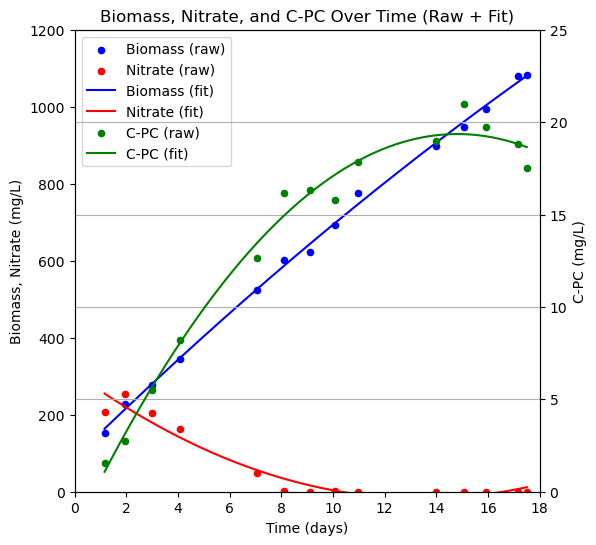

In [13]:
# Plot polynomial fit over original data

fig, ax1 = plt.subplots(figsize=(6, 6))
x_vals = data300["Time (Days)"] #grabs raw age values from original data to plot raw data


#plotting raw data for biomass and nitrate on left y-axis
ax1.scatter(x_vals, data300["Biomass (mg/mL)"], color='blue', label='Biomass (raw)',s=20)
ax1.scatter(x_vals, data300["Nitrate (mg/mL)"], color='red', label='Nitrate (raw)',s=20)

#draws a smooth biomass curve using predicted values (y_dense_bio/y_dense_nitrate) over a smooth time range (x_dense) for nitrate and biomass
ax1.plot(x300_dense, y300_dense_bio, color='blue', label='Biomass (fit)')
ax1.plot(x300_dense, y300_dense_nit, color='red', label='Nitrate (fit)')

#limits and labels for primary y-axis and x-axis (limits based on paper to make look the same)
ax1.set_xlabel("Time (days)")
ax1.set_ylabel("Biomass, Nitrate (mg/L)")
ax1.set_xlim(0, 18)
ax1.set_ylim(0, 1200)

#adds CPC on right axis
ax2 = ax1.twinx() #twin function creates secondary y-axis that shares same x-axis but has different units and limits than primary y-axis
#plots raw CPC data
ax2.scatter(data300["Time (Days)"], data300["C-PC (mg/mL)"], color='green', label='C-PC (raw)', s=20)
#plots smoothed fitted line over raw data
ax2.plot(x300_dense, y300_dense_cpc, color='green', label='C-PC (fit)')

#labels secondary y-axis and adds scale
ax2.set_ylabel("C-PC (mg/L)")
ax2.set_ylim(0, 25)

#combines legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

#adds title
plt.title("Biomass, Nitrate, and C-PC Over Time (Raw + Fit)")
#adds gridlines
plt.grid(True)

plt.show()

##### 600 mg/L Dataset

In [14]:
#adding 3rd order polynomial regression to CPC, nitrate, and biomass to replicate plot in paper
#using imputed data (above) and then generating smooth curves to plot

# Biomass
x600_bio = data600_imputed[["Time (Days)"]] # adds input x to regression
y600_bio = data600_imputed["Biomass (mg/mL)"]  #y target number one, biomass
poly600_bio = PolynomialFeatures(degree=2) #makes 3rd order polynomial 
x600_bio_poly = poly600_bio.fit_transform(x600_bio) #Actually creates the polynomial features from time values
model600_bio = LinearRegression().fit(x600_bio_poly, y600_bio) #trains the regression model to learn a curve that fits your biomass data over time

x600_vals=data600_imputed["Time (Days)"] #grabs full age column again to have range for smoothed values
x600_dense = np.linspace(x600_vals.min(), x600_vals.max(), 200).reshape(-1, 1) #makes 200 evenly spaced time points between first and last day and gives smooth line when predicting values between them

x600_dense_bio = poly600_bio.transform(x600_dense) #Turns smooth x-values into polynomial features
y600_dense_bio = model600_bio.predict(x600_dense_bio)#Uses the model to predict biomass values at all the smooth time points.

# Nitrate
nitrate_data600_imputed = data600_imputed.dropna(subset=["Nitrate (mg/mL)"])
x600_nit = nitrate_data600_imputed[["Time (Days)"]]
y600_nit = nitrate_data600_imputed["Nitrate (mg/mL)"]
poly600_nit = PolynomialFeatures(degree=2)
x600_nit_poly = poly600_nit.fit_transform(x600_nit)
model600_nit = LinearRegression().fit(x600_nit_poly, y600_nit)

x600_dense_nit = poly600_nit.transform(x600_dense)
y600_dense_nit = model600_nit.predict(x600_dense_nit)

# C-PC smoothing
cpc_data600_imputed = data600_imputed.dropna(subset=["C-PC (mg/mL)"])
x600_cpc = cpc_data600_imputed[["Time (Days)"]]
y600_cpc = cpc_data600_imputed["C-PC (mg/mL)"]
poly600_cpc = PolynomialFeatures(degree=2)
x600_cpc_poly = poly600_cpc.fit_transform(x600_cpc)
model600_cpc = LinearRegression().fit(x600_cpc_poly, y600_cpc)

x600_dense_cpc = poly600_cpc.transform(x600_dense)
y600_dense_cpc = model600_cpc.predict(x600_dense_cpc)

/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


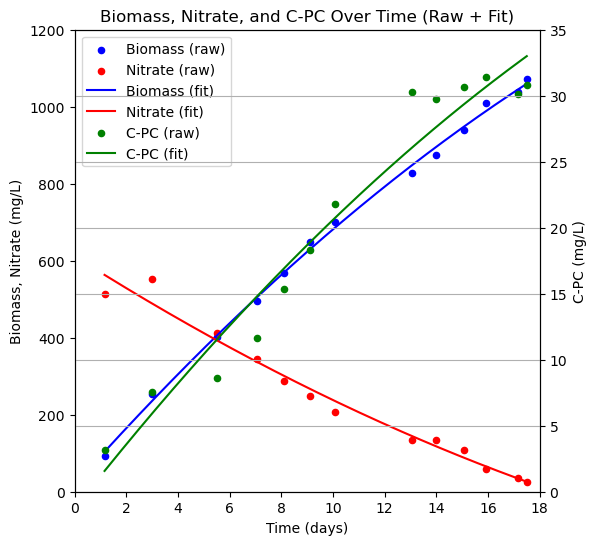

In [15]:
fig, ax1 = plt.subplots(figsize=(6, 6))
x_vals = data600["Time (Days)"] #grabs raw age values from original data to plot raw data


#plotting raw data for biomass and nitrate on left y-axis
ax1.scatter(x_vals, data600["Biomass (mg/mL)"], color='blue', label='Biomass (raw)',s=20)
ax1.scatter(x_vals, data600["Nitrate (mg/mL)"], color='red', label='Nitrate (raw)',s=20)

#draws a smooth biomass curve using predicted values (y_dense_bio/y_dense_nitrate) over a smooth time range (x_dense) for nitrate and biomass
ax1.plot(x600_dense, y600_dense_bio, color='blue', label='Biomass (fit)')
ax1.plot(x600_dense, y600_dense_nit, color='red', label='Nitrate (fit)')

#limits and labels for primary y-axis and x-axis (limits based on paper to make look the same)
ax1.set_xlabel("Time (days)")
ax1.set_ylabel("Biomass, Nitrate (mg/L)")
ax1.set_xlim(0, 18)
ax1.set_ylim(0, 1200)

#adds CPC on right axis
ax2 = ax1.twinx() #twin function creates secondary y-axis that shares same x-axis but has different units and limits than primary y-axis
#plots raw CPC data
ax2.scatter(data600["Time (Days)"], data600["C-PC (mg/mL)"], color='green', label='C-PC (raw)', s=20)
#plots smoothed fitted line over raw data
ax2.plot(x600_dense, y600_dense_cpc, color='green', label='C-PC (fit)')

#labels secondary y-axis and adds scale
ax2.set_ylabel("C-PC (mg/L)")
ax2.set_ylim(0, 35)

#combines legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

#adds title
plt.title("Biomass, Nitrate, and C-PC Over Time (Raw + Fit)")
#adds gridlines
plt.grid(True)

plt.show()

##### 900 mg/L Dataset

In [16]:
#adding 3rd order polynomial regression to CPC, nitrate, and biomass to replicate plot in paper
#using imputed data (above) and then generating smooth curves to plot

# Biomass
x900_bio = data900_imputed[["Time (Days)"]] # adds input x to regression
y900_bio = data900_imputed["Biomass (mg/mL)"]  #y target number one, biomass
poly900_bio = PolynomialFeatures(degree=2) #makes 3rd order polynomial 
x900_bio_poly = poly900_bio.fit_transform(x900_bio) #Actually creates the polynomial features from time values
model900_bio = LinearRegression().fit(x900_bio_poly, y900_bio) #trains the regression model to learn a curve that fits your biomass data over time

x900_vals=data900_imputed["Time (Days)"] #grabs full age column again to have range for smoothed values
x900_dense = np.linspace(x900_vals.min(), x900_vals.max(), 200).reshape(-1, 1) #makes 200 evenly spaced time points between first and last day and gives smooth line when predicting values between them

x900_dense_bio = poly900_bio.transform(x900_dense) #Turns smooth x-values into polynomial features
y900_dense_bio = model900_bio.predict(x900_dense_bio)#Uses the model to predict biomass values at all the smooth time points.

# Nitrate
nitrate_data900_imputed = data900_imputed.dropna(subset=["Nitrate (mg/mL)"])
x900_nit = nitrate_data900_imputed[["Time (Days)"]]
y900_nit = nitrate_data900_imputed["Nitrate (mg/mL)"]
poly900_nit = PolynomialFeatures(degree=2)
x900_nit_poly = poly900_nit.fit_transform(x900_nit)
model900_nit = LinearRegression().fit(x900_nit_poly, y900_nit)

x900_dense_nit = poly900_nit.transform(x900_dense)
y900_dense_nit = model900_nit.predict(x900_dense_nit)

# C-PC smoothing
cpc_data900_imputed = data900_imputed.dropna(subset=["C-PC (mg/mL)"])
x900_cpc = cpc_data900_imputed[["Time (Days)"]]
y900_cpc = cpc_data900_imputed["C-PC (mg/mL)"]
poly900_cpc = PolynomialFeatures(degree=2)
x900_cpc_poly = poly900_cpc.fit_transform(x900_cpc)
model900_cpc = LinearRegression().fit(x900_cpc_poly, y900_cpc)

x900_dense_cpc = poly900_cpc.transform(x900_dense)
y900_dense_cpc = model900_cpc.predict(x900_dense_cpc)

/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


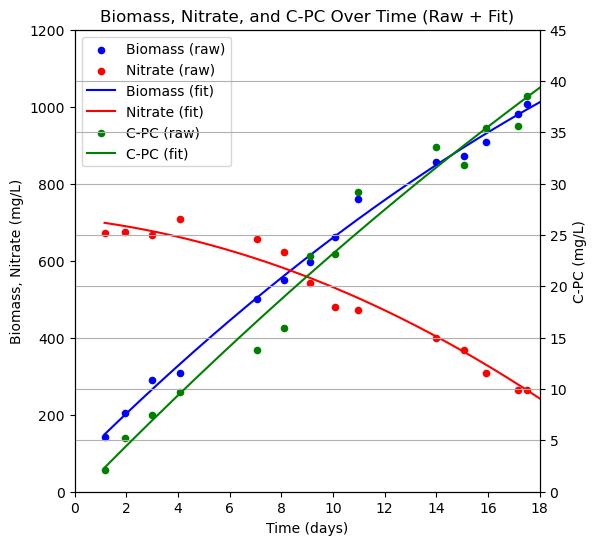

In [17]:
fig, ax1 = plt.subplots(figsize=(6, 6))
x_vals = data900["Time (Days)"] #grabs raw age values from original data to plot raw data


#plotting raw data for biomass and nitrate on left y-axis
ax1.scatter(x_vals, data900["Biomass (mg/mL)"], color='blue', label='Biomass (raw)',s=20)
ax1.scatter(x_vals, data900["Nitrate (mg/mL)"], color='red', label='Nitrate (raw)',s=20)

#draws a smooth biomass curve using predicted values (y_dense_bio/y_dense_nitrate) over a smooth time range (x_dense) for nitrate and biomass
ax1.plot(x900_dense, y900_dense_bio, color='blue', label='Biomass (fit)')
ax1.plot(x900_dense, y900_dense_nit, color='red', label='Nitrate (fit)')

#limits and labels for primary y-axis and x-axis (limits based on paper to make look the same)
ax1.set_xlabel("Time (days)")
ax1.set_ylabel("Biomass, Nitrate (mg/L)")
ax1.set_xlim(0, 18)
ax1.set_ylim(0, 1200)

#adds CPC on right axis
ax2 = ax1.twinx() #twin function creates secondary y-axis that shares same x-axis but has different units and limits than primary y-axis
#plots raw CPC data
ax2.scatter(data900["Time (Days)"], data900["C-PC (mg/mL)"], color='green', label='C-PC (raw)', s=20)
#plots smoothed fitted line over raw data
ax2.plot(x900_dense, y900_dense_cpc, color='green', label='C-PC (fit)')

#labels secondary y-axis and adds scale
ax2.set_ylabel("C-PC (mg/L)")
ax2.set_ylim(0, 45)

#combines legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

#adds title
plt.title("Biomass, Nitrate, and C-PC Over Time (Raw + Fit)")
#adds gridlines
plt.grid(True)

plt.show()

##### 1200 mg/L Dataset

In [18]:
#adding 3rd order polynomial regression to CPC, nitrate, and biomass to replicate plot in paper
#using imputed data (above) and then generating smooth curves to plot

# Biomass
x1200_bio = data1200_imputed[["Time (Days)"]] # adds input x to regression
y1200_bio = data1200_imputed["Biomass (mg/mL)"]  #y target number one, biomass
poly1200_bio = PolynomialFeatures(degree=2) #makes 3rd order polynomial 
x1200_bio_poly = poly1200_bio.fit_transform(x1200_bio) #Actually creates the polynomial features from time values
model1200_bio = LinearRegression().fit(x1200_bio_poly, y1200_bio) #trains the regression model to learn a curve that fits your biomass data over time

x1200_vals=data1200_imputed["Time (Days)"] #grabs full age column again to have range for smoothed values
x1200_dense = np.linspace(x1200_vals.min(), x1200_vals.max(), 200).reshape(-1, 1) #makes 200 evenly spaced time points between first and last day and gives smooth line when predicting values between them

x1200_dense_bio = poly1200_bio.transform(x1200_dense) #Turns smooth x-values into polynomial features
y1200_dense_bio = model1200_bio.predict(x1200_dense_bio)#Uses the model to predict biomass values at all the smooth time points.

# Nitrate
nitrate_data1200_imputed = data1200_imputed.dropna(subset=["Nitrate (mg/mL)"])
x1200_nit = nitrate_data1200_imputed[["Time (Days)"]]
y1200_nit = nitrate_data1200_imputed["Nitrate (mg/mL)"]
poly1200_nit = PolynomialFeatures(degree=2)
x1200_nit_poly = poly1200_nit.fit_transform(x1200_nit)
model1200_nit = LinearRegression().fit(x1200_nit_poly, y1200_nit)

x1200_dense_nit = poly1200_nit.transform(x1200_dense)
y1200_dense_nit = model1200_nit.predict(x1200_dense_nit)

# C-PC smoothing
cpc_data1200_imputed = data1200_imputed.dropna(subset=["C-PC (mg/mL)"])
x1200_cpc = cpc_data1200_imputed[["Time (Days)"]]
y1200_cpc = cpc_data1200_imputed["C-PC (mg/mL)"]
poly1200_cpc = PolynomialFeatures(degree=2)
x1200_cpc_poly = poly1200_cpc.fit_transform(x1200_cpc)
model1200_cpc = LinearRegression().fit(x1200_cpc_poly, y1200_cpc)

x1200_dense_cpc = poly1200_cpc.transform(x1200_dense)
y1200_dense_cpc = model1200_cpc.predict(x1200_dense_cpc)

/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
/opt/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


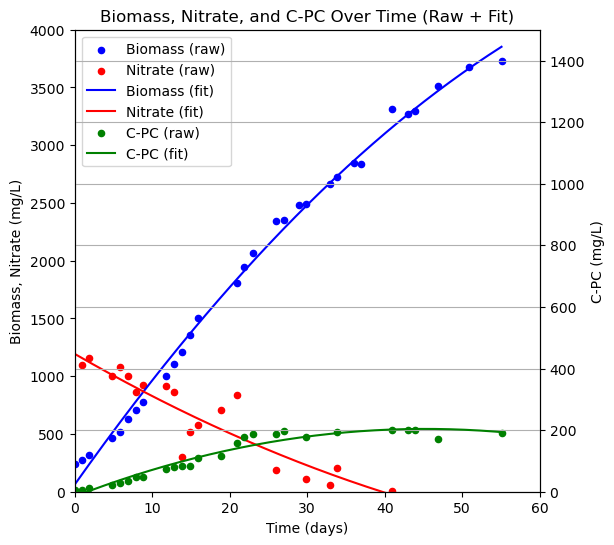

In [19]:
fig, ax1 = plt.subplots(figsize=(6, 6))
x_vals = data1200["Time (Days)"] #grabs raw age values from original data to plot raw data


#plotting raw data for biomass and nitrate on left y-axis
ax1.scatter(x_vals, data1200["Biomass (mg/mL)"], color='blue', label='Biomass (raw)',s=20)
ax1.scatter(x_vals, data1200["Nitrate (mg/mL)"], color='red', label='Nitrate (raw)',s=20)

#draws a smooth biomass curve using predicted values (y_dense_bio/y_dense_nitrate) over a smooth time range (x_dense) for nitrate and biomass
ax1.plot(x1200_dense, y1200_dense_bio, color='blue', label='Biomass (fit)')
ax1.plot(x1200_dense, y1200_dense_nit, color='red', label='Nitrate (fit)')

#limits and labels for primary y-axis and x-axis (limits based on paper to make look the same)
ax1.set_xlabel("Time (days)")
ax1.set_ylabel("Biomass, Nitrate (mg/L)")
ax1.set_xlim(0, 60)
ax1.set_ylim(0, 4000)

#adds CPC on right axis
ax2 = ax1.twinx() #twin function creates secondary y-axis that shares same x-axis but has different units and limits than primary y-axis
#plots raw CPC data
ax2.scatter(data1200["Time (Days)"], data1200["C-PC (mg/mL)"], color='green', label='C-PC (raw)', s=20)
#plots smoothed fitted line over raw data
ax2.plot(x1200_dense, y1200_dense_cpc, color='green', label='C-PC (fit)')

#labels secondary y-axis and adds scale
ax2.set_ylabel("C-PC (mg/L)")
ax2.set_ylim(0, 1500)

#combines legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

#adds title
plt.title("Biomass, Nitrate, and C-PC Over Time (Raw + Fit)")
#adds gridlines
plt.grid(True)

plt.show()

##### Format Polynomial Predicted Values into DataFrame for each Dataset

In [20]:
time300 = np.arange(18) # create time array with values 0-17, as done in original paper
time300_features = poly300_bio.fit_transform(time300.reshape(-1,1)) #Actually creates the polynomial features from time values, which are the same for each model

biomass300_pred = model300_bio.predict(time300_features) #predicted biomass values for time steps
nit300_pred = model300_nit.predict(time300_features) #predicted nitrogen values for time steps
cpc300_pred = model300_cpc.predict(time300_features) #predicted cpc values for time steps
cpc300_pred = np.clip(cpc300_pred, 0, None)

# Store times and predicted biomass, nitrate, and C-PC in one dataframe
fitted300_df = pd.DataFrame({'Time (Days)': time300, 
                             'Biomass (mg/mL)': biomass300_pred, 
                             'Nitrate (mg/mL)': nit300_pred, 
                             'C-PC (mg/mL)':cpc300_pred})
fitted300_df.head() # print the first few rows

,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,0,88.589030,308.549615,0.000000
1,1,153.728823,261.838030,0.665598
2,2,217.843420,218.733146,3.274046
3,3,280.932821,179.234963,5.686531
4,4,342.997027,143.343480,7.903056


In [21]:
time600 = np.arange(18) # create time array with values 0-17, as done in original paper
time600_features = poly600_bio.fit_transform(time600.reshape(-1,1)) #Actually creates the polynomial features from time values, which are the same for each model

biomass600_pred = model600_bio.predict(time600_features) #predicted biomass values for time steps
nit600_pred = model600_nit.predict(time600_features) #predicted nitrogen values for time steps
cpc600_pred = model600_cpc.predict(time600_features) #predicted cpc values for time steps
cpc600_pred = np.clip(cpc600_pred, 0, None)

# Store times and predicted biomass, nitrate, and C-PC in one dataframe
fitted600_df = pd.DataFrame({'Time (Days)': time600, 
                             'Biomass (mg/mL)': biomass600_pred, 
                             'Nitrate (mg/mL)': nit600_pred, 
                             'C-PC (mg/mL)':cpc600_pred})
fitted600_df.head()

,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,0,18.164890,611.586565,0.000000
1,1,92.708596,569.540282,1.203063
2,2,165.432238,528.533855,3.602857
3,3,236.335815,488.567283,5.941685
4,4,305.419328,449.640567,8.219545


In [22]:
time900 = np.arange(18) # create time array with values 0-17, as done in original paper
time900_features = poly900_bio.fit_transform(time900.reshape(-1,1)) #Actually creates the polynomial features from time values, which are the same for each model

biomass900_pred = model900_bio.predict(time900_features) #predicted biomass values for time steps
nit900_pred = model900_nit.predict(time900_features) #predicted nitrogen values for time steps
cpc900_pred = model900_cpc.predict(time900_features) #predicted cpc values for time steps
cpc900_pred = np.clip(cpc900_pred, 0, None)

# Store times and predicted biomass, nitrate, and C-PC in one dataframe
fitted900_df = pd.DataFrame({'Time (Days)': time900, 
                             'Biomass (mg/mL)': biomass900_pred, 
                             'Nitrate (mg/mL)': nit900_pred, 
                             'C-PC (mg/mL)':cpc900_pred})
fitted900_df.head()

,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,0,72.884046,708.394048,0.000000
1,1,138.974572,699.880097,1.954695
2,2,203.426212,689.320059,4.476118
3,3,266.238968,676.713931,6.957387
4,4,327.412839,662.061716,9.398504


In [23]:
time1200 = np.arange(56) # create time array with values 0-55, as done in original paper
time1200_features = poly1200_bio.fit_transform(time1200.reshape(-1,1)) #Actually creates the polynomial features from time values, which are the same for each model

biomass1200_pred = model1200_bio.predict(time1200_features) #predicted biomass values for time steps
nit1200_pred = model1200_nit.predict(time1200_features) #predicted nitrogen values for time steps
cpc1200_pred = model1200_cpc.predict(time1200_features) #predicted cpc values for time steps
cpc1200_pred = np.clip(cpc1200_pred, 0, None)

# Store times and predicted biomass, nitrate, and C-PC in one dataframe
fitted1200_df = pd.DataFrame({'Time (Days)': time1200, 
                             'Biomass (mg/mL)': biomass1200_pred, 
                             'Nitrate (mg/mL)': nit1200_pred, 
                             'C-PC (mg/mL)':cpc1200_pred})
fitted1200_df.head()

,Time (Days),Biomass (mg/mL),Nitrate (mg/mL),C-PC (mg/mL)
0,0,62.755571,1193.011602,0.000000
1,1,157.190226,1154.556892,0.000000
2,2,250.677447,1116.534658,3.686594
3,3,343.217234,1078.944901,12.847918
4,4,434.809588,1041.787621,21.794757


---
## ANN

#### Format Training Data

In [24]:
# Need to define output data as the delta between the current and next time step
def create_training_data(df):
    X = []
    Y = []
    for i in range(len(df) - 1):
        t, x, N, C_PC = df.iloc[i][['Time (Days)', 'Biomass (mg/mL)', 'Nitrate (mg/mL)', 'C-PC (mg/mL)']]
        t_next, x_next, N_next, C_PC_next = df.iloc[i+1][['Time (Days)', 'Biomass (mg/mL)', 'Nitrate (mg/mL)', 'C-PC (mg/mL)']]

        input_vec = [t, x, N, C_PC]
        output_vec = [t_next - t, x_next - x, N_next - N, C_PC_next - C_PC]

        X.append(input_vec)
        Y.append(output_vec)

    return np.array(X), np.array(Y)

# Load and process all 3 experiments
X_all, Y_all = [], []
for df in [fitted300_df, fitted900_df, fitted1200_df]:
    X, Y = create_training_data(df)
    X_all.append(X)
    Y_all.append(Y)

# Stack all together
X_train = np.vstack(X_all)
Y_train = np.vstack(Y_all)

In [25]:
# Create validation set from 600 mg/L data set

X_validation, Y_validation = create_training_data(fitted600_df)

In [26]:
# Scale data to a mean of zero and a mean of 0 and standard deviation of 1

# create instances of scalers
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# fit to training data and scale training data
X_train_scaled = scaler_X.fit_transform(X_train)
Y_train_scaled = scaler_Y.fit_transform(Y_train)

# scale validation data
X_validation_scaled = scaler_X.transform(X_validation)
Y_validation_scaled = scaler_Y.transform(Y_validation)

#### Importing packages and building model

In [27]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
# Modified version with 600 mg/L experiment used as validation set, other three experiments used as training data
    # (as opposed to using a 15% validation split from the three training experiments)

# === Define the model ===
model = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),   # Input layer (4) → Hidden 1
    Dense(64, activation='relu'),                      # Hidden 2
    Dropout(0.15),                                     # Dropout (keep_prob=0.85)
    Dense(4)                                           # Output layer (Δt, Δx, ΔN, ΔC-PC)
])

# === Compile model ===
model.compile(optimizer=Adam(), loss='mse')

# === Train the model ===
history = model.fit(X_train_scaled, Y_train_scaled,
                    epochs=10000,               # Feel free to reduce to ~1000 to test first
                    batch_size=16,
                    validation_data=(X_validation_scaled, Y_validation_scaled),      # or use an explicit X_val/Y_val if you prefer
                    verbose=1)                  # Set to 1 if you want to watch training live

# === Plot training + validation loss ===
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('ANN Training and Validation Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("Loss_v_Epoch.png")

# === Save model ===
model.save('plectonema_ann_model_mostrecent.h5')
print("Model saved as 'plectonema_ann_model_mostrecent.h5'")


#### Load in Model from Saved Parameters and Fit Validation Set

In [28]:
# === Define the model ===
ann_model = Sequential([
    Dense(64, activation='relu', input_shape=(4,)),   # Input layer (4) → Hidden 1
    Dense(64, activation='relu'),                      # Hidden 2
    Dropout(0.15),                                     # Dropout (keep_prob=0.85)
    Dense(4)                                           # Output layer (Δt, Δx, ΔN, ΔC-PC)
])

# === Compile model ===
ann_model.compile(optimizer=Adam(), loss=tf.keras.losses.MeanSquaredError())

# === Load in weights from saved file ====
ann_model.load_weights("plectonema_ann_model_mostrecent.h5")

/home/murra349/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-22 13:55:30.176503: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [29]:
# define initial state as first row of data from validation set
current_state = scaler_X.transform(np.array([1, data600.loc[0,"Biomass (mg/mL)"], data600.loc[0,"Nitrate (mg/mL)"], data600.loc[0,"C-PC (mg/mL)"]]).reshape(1, -1))

t_range = range(1, 18) # time range to run through days 1-17
trajectory = [current_state.copy()] # create a list to store each state for future plotting

for t in t_range:
    
    # Predict the delta in scaled space
    delta_scaled = ann_model.predict(current_state, verbose=0)
    
    # Unscale both delta and current state
    delta_unscaled = scaler_Y.inverse_transform(delta_scaled)[0]
    current_state_unscaled = scaler_X.inverse_transform(current_state)[0]
    
    # Add delta to unscaled state
    next_state_unscaled = current_state_unscaled + delta_unscaled
    
    # Re-scale the new state for the next prediction
    current_state = scaler_X.transform(next_state_unscaled.reshape(1, -1))

    # Save the new state
    trajectory.append(current_state.copy())

# Convert trajectory to NumPy array for easier handling
trajectory = np.array(trajectory)
trajectory_unscaled = scaler_X.inverse_transform(trajectory.reshape(-1, trajectory.shape[-1]))

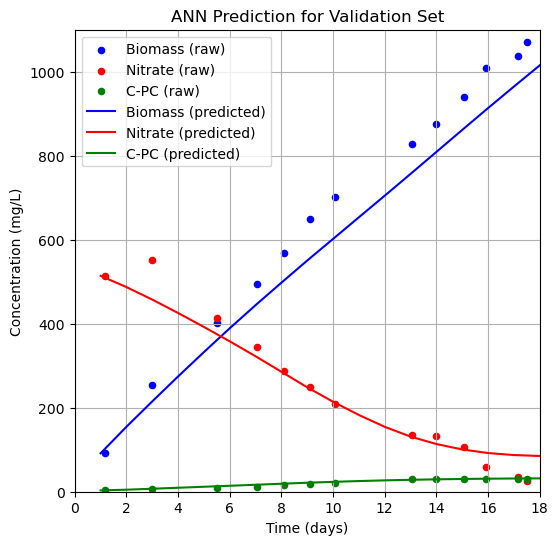

In [30]:
# Plot ANN prediction

fig, ax1 = plt.subplots(figsize=(6, 6))
x_vals = data600["Time (Days)"] #grabs raw age values from original data to plot raw data

ax1.scatter(x_vals, data600["Biomass (mg/mL)"], color='blue', label='Biomass (raw)',s=20)
ax1.scatter(x_vals, data600["Nitrate (mg/mL)"], color='red', label='Nitrate (raw)',s=20)
ax1.scatter(x_vals, data600["C-PC (mg/mL)"], color='green', label='C-PC (raw)',s=20)

plt.plot(trajectory_unscaled[:,0], trajectory_unscaled[:,1],  color='blue', label='Biomass (predicted)')
plt.plot(trajectory_unscaled[:,0], trajectory_unscaled[:,2],  color='red', label='Nitrate (predicted)')
plt.plot(trajectory_unscaled[:,0], trajectory_unscaled[:,3],  color='green', label='C-PC (predicted)')

#limits and labels for primary y-axis and x-axis (limits based on paper to make look the same)
ax1.set_xlabel("Time (days)")
ax1.set_ylabel("Concentration (mg/L)")
ax1.set_xlim(0, 18)
ax1.set_ylim(0, 1100)
plt.legend()

#adds title
plt.title("ANN Prediction for Validation Set")
#adds gridlines
plt.grid(True)

plt.show()

In [31]:
 UPDATE_FREQ = 20  # print average reward every 20 episodes

# === Environment- simulates bioreactor environment, takes data from 600 mg/L nitrate 
class BioreactorEnv:
    def __init__(self, ann_model, scaler_X, scaler_Y, data600, max_nitrate=2000): #Initializes the environment. Takes a trained ANN model and scalers for input/output, a dataset(dataset600), and a limit on how much nitrate can be added (taken from paper)
        self.ann_model = ann_model
        self.scaler_X = scaler_X
        self.scaler_Y = scaler_Y
        self.data600 = data600
        self.max_steps = 17 #environment ends after 17 steps
        self.max_nitrate = max_nitrate
        self.dose_values = [0, 50, 100, 150, 200, 250] #agent can add these dose values
        self.reset() #calls reset to initialize to first  state

    def _get_initial_state(self):
        return np.array([
            1,
            self.data600.loc[0, "Biomass (mg/mL)"],
            self.data600.loc[0, "Nitrate (mg/mL)"],
            self.data600.loc[0, "C-PC (mg/mL)"]
        ])

    def reset(self):
        self.current_step = 0
        self.total_nitrate_added = 0
        self.unscaled_state = self._get_initial_state()
        self.scaled_state = self.scaler_X.transform([self.unscaled_state])[0]
        return self.scaled_state

    def step(self, action):
    # === Apply Nitrate Dose ===
        n_add = self.dose_values[action]
        if self.total_nitrate_added + n_add > self.max_nitrate:
            n_add = 0  # Prevent exceeding nitrate limit
        self.total_nitrate_added += n_add

    # === Update nitrate in the unscaled state ===
        self.unscaled_state[2] += n_add  # Add to nitrate concentration

    # === Predict next state using ANN model ===
        input_scaled = self.scaler_X.transform([self.unscaled_state])[0]
        delta_scaled = self.ann_model.predict(np.array([input_scaled]), verbose=0)
        delta_unscaled = self.scaler_Y.inverse_transform(delta_scaled)[0]

        next_unscaled = self.unscaled_state + delta_unscaled
        self.current_step += 1
        done = self.current_step >= self.max_steps

    # === Reward Calculation ===
        if done:
            biomass = max(next_unscaled[1], 1e-6)
            cpc = next_unscaled[3]
            raw_yield = cpc / biomass

        # Normalize reward to be between 0 and 1 (optional)
        # You can adjust expected_min/max based on paper data
            expected_min_yield = 0.5
            expected_max_yield = 3.0
            normalized_yield = (raw_yield - expected_min_yield) / (expected_max_yield - expected_min_yield)
            normalized_yield = max(0, min(1, normalized_yield))  # Clamp to [0, 1]

            reward = normalized_yield

        else:
        # Optional: discourage adding nitrate later in the run
        # Earlier nitrate addition is encouraged
            day_penalty = self.current_step / self.max_steps
            reward = -0.1 - 0.001 * day_penalty * n_add  # Penalty grows with time and nitrate dose
    
    # === Update state ===
        self.unscaled_state = next_unscaled
        self.scaled_state = self.scaler_X.transform([self.unscaled_state])[0]
        return self.scaled_state, reward, done, {}


#Called each time the agent acts. It: 
#Adds nitrate based on the action

#Predicts next state using the trained ANN

#Calculates reward

#If simulation is done → C-PC / biomass (target metric)

#Else → penalty -0.1

#Returns the new state, reward, and whether the episode is over

# === Actor-Critic Model ===
class ActorCriticModel(Model): #defines neural network that agent uses to decide what to do
    def __init__(self):
        super().__init__()
        self.dense1 = Dense(200, activation='relu')
        self.logits = Dense(6)  # 6 nitrate dose levels, logits=raw action scores used to pick actions
        self.dense2 = Dense(200, activation='relu')
        self.value = Dense(1) #estimates value of current state, value=how good current state is

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.logits(x), self.value(self.dense2(x))

    #when you pass data through actor-critic model, it gives logits and values

class A3CAgent(threading.Thread): #each agent runs its own thread and has its own copy of environment and local version of actor-critic model
    def __init__(self, global_model, optimizer, ann_model, scaler_X, scaler_Y, data600):
        super().__init__()
        self.global_model = global_model
        self.optimizer = optimizer
        self.local_model = ActorCriticModel()
        self.local_model(tf.convert_to_tensor(np.zeros((1, 4)), dtype=tf.float32))
        self.local_model.set_weights(global_model.get_weights())
        self.env = BioreactorEnv(ann_model, scaler_X, scaler_Y, data600)

    def run(self):
        global global_episode, global_rewards, global_step, reward_steps, lock

        while True:
            with lock:
                if global_episode >= MAX_EPISODES:
                    break
                episode_num = global_episode
                global_episode += 1

            state = self.env.reset()
            done = False
            episode_reward = 0

            while not done:
                state_tensor = tf.convert_to_tensor(np.expand_dims(state, 0), dtype=tf.float32)
                logits, _ = self.local_model(state_tensor)
                action = tf.random.categorical(logits, 1)[0, 0].numpy()

                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                state = next_state

                with lock:
                    global_step += 1
                    global_rewards.append(reward)
                    if len(global_rewards) >= 20:
                        avg = np.mean(global_rewards[-20:])
                        reward_steps.append(avg)

            with lock:
                if episode_num % UPDATE_FREQ == 0:
                    print(f"[Episode {episode_num}] Avg Reward (last 20 steps): {np.mean(global_rewards[-20:]):.4f}")
#runs agent loop
#resets environment
#takes actions
#receives reward
#updates shared training metrics(reward, step count)

# === Training Entry Point ===
def train_a3c(ann_model, scaler_X, scaler_Y, data600, episodes=2000, agents=4):#this function starts the training
    global global_episode, global_rewards, global_step, reward_steps, MAX_EPISODES, lock
    global_episode = 0
    global_rewards = []
    reward_steps = []
    global_step = 0
    MAX_EPISODES = episodes
    lock = threading.Lock()

    global_model = ActorCriticModel() #central model that all agents update
    global_model(tf.convert_to_tensor(np.zeros((1, 4)), dtype=tf.float32))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    agent_threads = [
        A3CAgent(global_model, optimizer, ann_model, scaler_X, scaler_Y, data600)
        for _ in range(agents)
    ]  #starts 4 agents (default) all running in parallel

    for agent in agent_threads:#runs all agents
        agent.start()
    for agent in agent_threads: #waits for all agents to finish training
        agent.join()

   

    # Plotting moving average reward over time
    plt.figure(figsize=(8, 5))
    plt.plot(reward_steps)
    plt.xlabel("Step")
    plt.ylabel("Moving Avg Reward (20 steps)")
    plt.title("A3C Learning Curve (C-PC / Biomass)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    return global_model



In [33]:
trained_model = train_a3c(ann_model, scaler_X, scaler_Y, data600, episodes=2000, agents=4)
trained_model.save_weights("a3c_global_model.weights.h5")

#Creates 4 A3C agents, each with its own environment and local model
#Each agent:
#-Simulates 17 days of bioreactor behavior
#-Chooses nitrate doses each day
#-Gets reward at the end (C-PC / Biomass)
#-All agents send updates to a shared global model
#-Every 20 episodes, prints the average reward
#At the end, plots the learning curve and returns the trained model


[Episode 0] Avg Reward (last 20 steps): -0.1396
[Episode 20] Avg Reward (last 20 steps): -0.1616


KeyboardInterrupt: 

In [ ]:
# Re-create the same model structure
trained_model = ActorCriticModel()
trained_model(tf.convert_to_tensor(np.zeros((1, 4)), dtype=tf.float32))  # initialize shape
trained_model.load_weights("a3c_global_model.weights.h5")
print("Loaded trained A3C model from saved file.")
# This function runs a full 17-day simulation using the trained RL model.
# It uses the BioreactorEnv to simulate how the agent interacts with the 
# bioreactor each day by selecting a nitrate dose from a discrete set.
# At each step, the function:
# - Uses the trained actor-critic model to choose a nitrate dose
# - Tracks the nitrate added, biomass, and C-PC concentration
# - Steps through the environment using the ANN-based simulation
#
# At the end, it plots the nitrate dosing strategy the agent followed.
# This helps visualize what policy the agent learned and compare it 
# to the nitrate addition pattern shown in the original paper.
#
# Optionally, it returns all tracked data for further analysis.

def simulate_agent(trained_model, ann_model, scaler_X, scaler_Y, data600):
    env = BioreactorEnv(ann_model, scaler_X, scaler_Y, data600)
    state = env.reset()
    done = False

    nitrate_doses = []
    cpc_vals = []
    biomass_vals = []
    days = []

    while not done:
        state_tensor = tf.convert_to_tensor(np.expand_dims(state, 0), dtype=tf.float32)
        logits, _ = trained_model(state_tensor)
        action = tf.random.categorical(logits, 1)[0, 0].numpy()

        # Get nitrate value for the action
        dose = env.dose_values[action]
        nitrate_doses.append(dose)

        # Save current C-PC and biomass from unscaled state
        unscaled = scaler_X.inverse_transform([state])[0]
        days.append(unscaled[0])
        biomass_vals.append(unscaled[1])
        cpc_vals.append(unscaled[3])

        # Take step
        state, reward, done, _ = env.step(action)

    # Plot nitrate addition strategy
    plt.figure(figsize=(8, 4))
    plt.plot(days, nitrate_doses, marker='o')
    plt.xlabel("Day")
    plt.ylabel("Nitrate Added (mg/L)")
    plt.title("Agent’s Nitrate Dosing Strategy Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Optional: return for more plots
    return days, nitrate_doses, biomass_vals, cpc_vals


In [ ]:
#actually runs model
simulate_agent(trained_model, ann_model, scaler_X, scaler_Y, data600)
